Здесь собраны и тестятся все применяемые в рамках текущей задачи методы

In [4]:
# ! git clone -b ml_and_stat_methods https://github.com/mipt-nd/novelty-detection.git
# %cd novelty-detection/

In [5]:
# ! pip install pyod -q
# ! pip install suod -q

In [6]:
import os
import random
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# adfuller
from statsmodels.tsa.stattools import adfuller

def seed_everything(seed):
    # фискирует максимум сидов для корректности сравнения разных экспериментов
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
SEED = 42
seed_everything(SEED)

# Datasets

In [7]:
# Синтетически сгенерированные нормально распределенные данные
def make_norm_data(rows, columns, noise_percent=0.05):
    data_norm = pd.DataFrame(data=np.random.normal(
                            loc=0, scale=1, size=(rows, columns)))
    noise = pd.DataFrame(data=np.random.uniform(
                            low=-6, high=6, size=(int(data_norm.shape[0]*noise_percent), data_norm.shape[1])))

    data_noise = pd.DataFrame()
    for feature in noise.columns:
        filter = (
            (noise[feature] < data_norm[feature].min())
            | (noise[feature] > data_norm[feature].max())
            )
        data_noise = pd.concat([data_noise, noise[filter]])
    data_noise = data_noise.drop_duplicates()
    data_norm['anomaly'] = 0
    data_noise['anomaly'] = 1

    df_norm = pd.concat((data_norm, data_noise))
    return df_norm

df_norm = make_norm_data(1000, 8)
df_norm

,0,1,2,3,4,5,6,7,anomaly
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,0
1,-0.469474,0.542560,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,0
2,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,0
3,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,0
4,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,0
...,...,...,...,...,...,...,...,...,...
32,0.063984,1.772509,0.031678,-0.098264,-3.938531,-2.655435,-4.093768,-3.652004,1
38,-2.800126,2.593122,-1.268901,2.124984,-0.288220,5.925277,2.746826,5.429896,1
5,2.151800,-0.353991,-1.345218,-1.488481,1.680586,-0.062468,4.189587,4.496424,1
37,-2.554173,0.008819,-0.528646,-1.866863,2.324896,3.114742,4.235808,5.674279,1


In [8]:
# SKAB data

all_files=[]
for root, dirs, files in os.walk("data_labeled/SKAB/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    # print(path, df.shape)
    dfs.append(df)
# print('Features:')
# for col in dfs[2].columns:
#     print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
# print(df_skab.shape)
df_skab = df_skab.drop_duplicates()
df_skab = df_skab.drop('changepoint', axis=1).reset_index().sort_index()
display(df_skab)

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly
0,2020-03-09 10:54:34,0.026990,0.040407,1.015510,0.382638,72.9570,25.6198,231.276,31.00100,0.0
1,2020-03-09 10:54:35,0.026836,0.039138,1.020390,0.054711,72.8664,25.6185,226.683,31.99900,0.0
2,2020-03-09 10:54:36,0.026597,0.040147,0.733759,0.054711,72.8498,25.6157,231.091,31.00100,0.0
3,2020-03-09 10:54:37,0.027161,0.040001,1.073280,0.382638,72.7915,25.6115,236.156,31.99900,0.0
4,2020-03-09 10:54:38,0.026703,0.039407,1.106890,0.054711,72.9818,25.6171,207.464,31.00100,0.0
...,...,...,...,...,...,...,...,...,...,...
36915,2020-02-08 19:32:15,0.105811,0.193051,1.291030,0.054711,86.1452,33.2491,208.855,122.47500,0.0
36916,2020-02-08 19:32:16,0.060570,0.077031,0.824930,0.382638,86.2657,33.2489,227.430,98.54010,0.0
36917,2020-02-08 19:32:17,0.024764,0.037350,0.293163,0.382638,86.5109,33.2445,228.719,69.18940,0.0
36918,2020-02-08 19:32:18,0.017131,0.016978,0.220920,0.054711,86.2620,33.2386,245.183,17.65750,0.0


In [10]:
# labeled data

df_pageblocks = pd.read_csv('data_labeled/pageblocks_16.csv')
df_pageblocks = df_pageblocks.rename(columns={'label': 'anomaly'})
df_shuttle = pd.read_csv('data_labeled/shuttle_16.csv')
df_shuttle = df_shuttle.rename(columns={'label': 'anomaly'})
print('df_pageblocks')
display(df_pageblocks.head())
print('df_shuttle')
display(df_shuttle.head())

df_pageblocks


,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,anomaly
0,0.004981,0.010870,0.000194,0.002594,0.367089,0.634328,0.000268,0.000212,0.000347,0.001557,0
1,0.006227,0.010870,0.000243,0.002160,0.397679,0.873134,0.000525,0.000333,0.000650,0.001246,0
2,0.006227,0.030797,0.000701,0.005574,0.247890,0.723881,0.000692,0.000727,0.001583,0.001869,0
3,0.004981,0.010870,0.000194,0.002594,0.336498,0.726013,0.000672,0.000182,0.000412,0.000623,0
4,0.006227,0.003623,0.000076,0.000918,0.472574,0.940299,0.000252,0.000061,0.000217,0.000934,0


df_shuttle


,att1,att2,att3,att4,att5,att6,att7,att8,att9,anomaly
0,0.214286,0.607955,0.12766,0.020145,0.207865,0.088428,0.347222,0.746875,0.737113,1
1,0.085714,0.607955,0.12766,0.020145,0.207865,0.088428,0.458333,0.746875,0.716495,1
2,0.200000,0.607955,0.12766,0.020145,0.067416,0.088428,0.361111,0.912500,0.871134,1
3,0.085714,0.602273,0.12766,0.020145,0.207865,0.088428,0.472222,0.746875,0.716495,1
4,0.185714,0.653409,0.12766,0.020145,0.067416,0.088428,0.375000,0.912500,0.865979,1


In [11]:
datasets = {
    'df_norm': {
        'df': df_norm,
    },
    'df_skab': {
        'df': df_skab,
        'time_series': True,
    },
    'df_pageblocks': {
        'df': df_pageblocks,
    },
    'df_shuttle': {
        'df': df_shuttle,
    },
}

# Применение теста Дики-Фуллера ко временному ряду

In [12]:

# Проверка стационарности ряда
for df_name, dataset in datasets.items():
    df = dataset['df']
    time_series = dataset.get('time_series', False)
    if not time_series:
        continue
    print(df_name)
    for col in tqdm(df.columns):
        result = adfuller(df[col])
        # print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        # print('Critical Values:')
        # for key, value in result[4].items():
        #     print('\t%s: %.3f' % (key, value))

        # Применение теста Дики-Фуллера к ряду
        result = adfuller(df[col])
        if result[1] < 0.05:
            print(f'Ряд {col} стационарен')
        else:
            print(f'Ряд {col} нестационарен. Возможно, есть аномалии в данных')
    print('-'*10)

df_skab


  0%|          | 0/10 [00:00<?, ?it/s]

p-value: 0.829638
Ряд datetime нестационарен. Возможно, есть аномалии в данных
p-value: 0.000529
Ряд Accelerometer1RMS стационарен
p-value: 0.000883
Ряд Accelerometer2RMS стационарен
p-value: 0.000433
Ряд Current стационарен
p-value: 0.000000
Ряд Pressure стационарен
p-value: 0.509625
Ряд Temperature нестационарен. Возможно, есть аномалии в данных
p-value: 0.260784
Ряд Thermocouple нестационарен. Возможно, есть аномалии в данных
p-value: 0.000000
Ряд Voltage стационарен
p-value: 0.072153
Ряд Volume Flow RateRMS нестационарен. Возможно, есть аномалии в данных
p-value: 0.000000
Ряд anomaly стационарен
----------


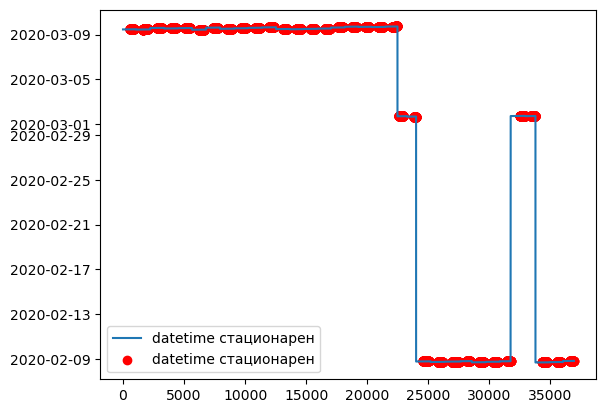

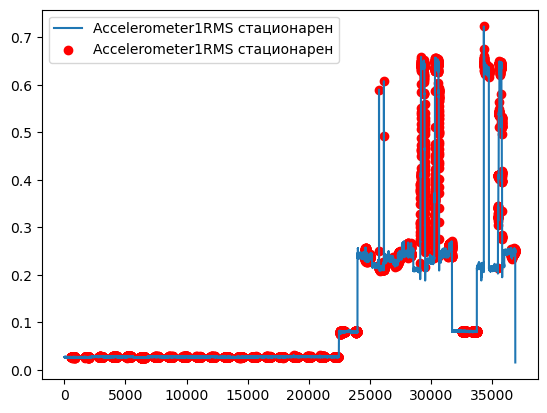

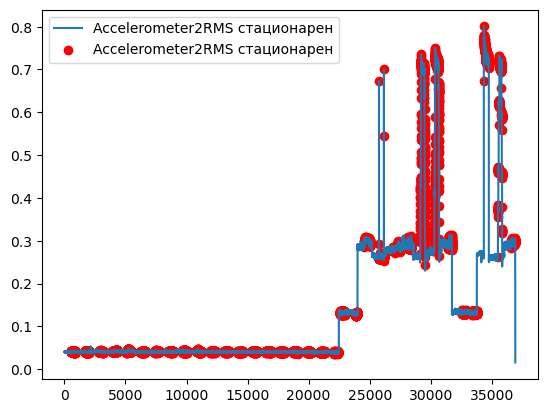

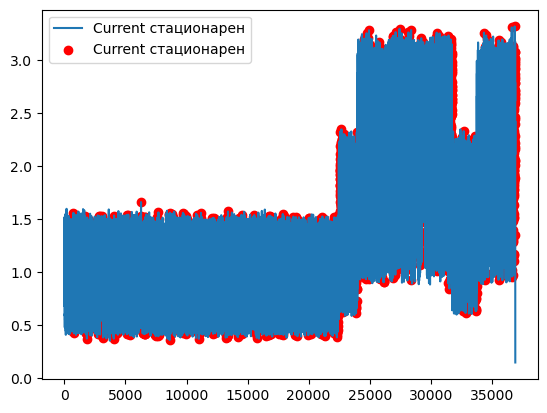

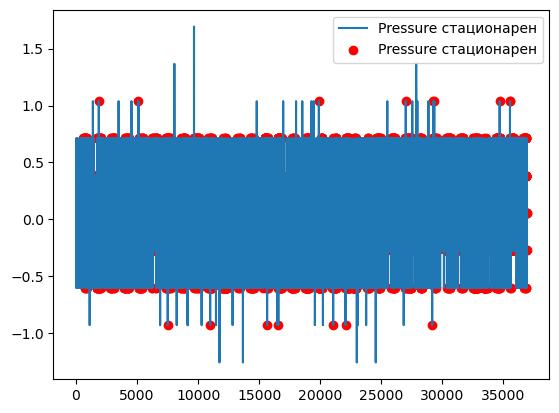

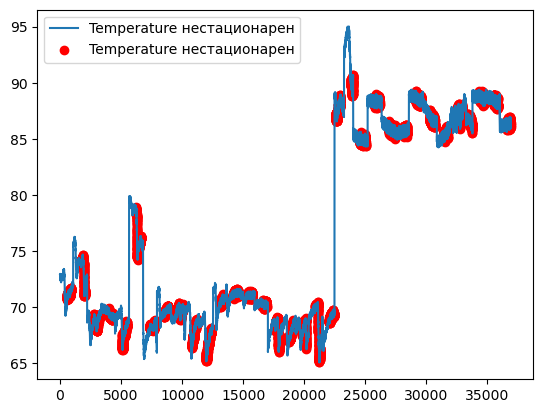

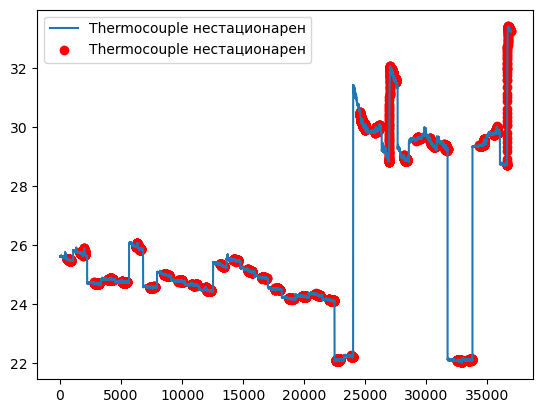

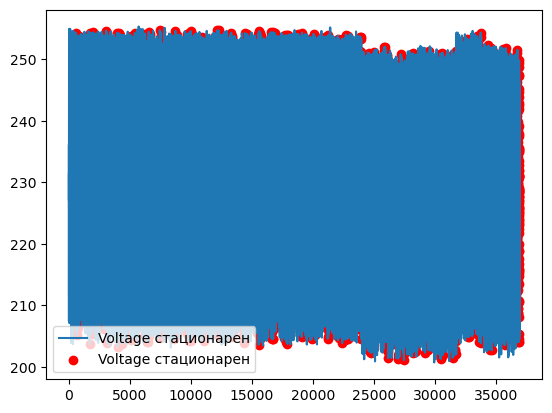

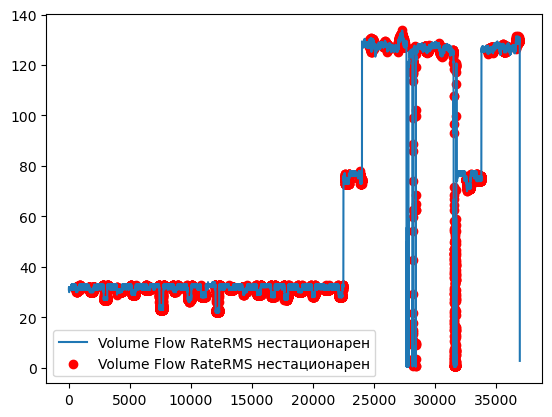

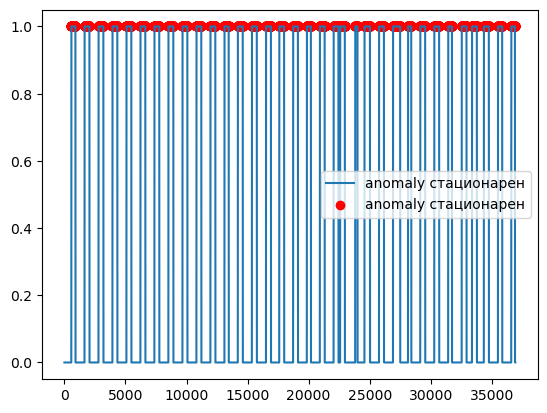

In [29]:
import matplotlib.pyplot as plt
plt.

for col in df_skab.columns:
    non_stat_cols =  ['Temperature', 'Thermocouple', 'Volume Flow RateRMS']
    label = f'{col} нестационарен' if col in non_stat_cols else f'{col} стационарен'
    plt.plot(df_skab[col], label=label)
    plt.scatter(df_skab[df_skab['anomaly'] == 1].index, df_skab[df_skab['anomaly'] == 1][col], label=label, c='r')
    plt.legend()
    plt.show()